In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Keypoint Detection

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB 转换颜色通道
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results): # Can comment face and hand part
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections 新版本有更新FACEMESH_TESSELATION
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results): # 给连线添加属性 如果没加 就是绿色的
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,  # FACE_CONNECTIONS -> FACEMESH_TESSELATION
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
def extract_keypoints(results): # Can comment face and hand part
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) # ([pose, face, lh, rh])

# Setup Folders for Collection

In [7]:
motions = np.array(['Left_punch', 'Right_punch', 'Wakanda', 'Kiss', 'No_action'])
DATA_PATH_TR = os.path.join('Train Data') # path of keypoint detection file of training data
DATA_PATH_TE = os.path.join('Test Data') # path of keypoint detection file of test data

# Thirty videos worth of data
no_sequences = 60

# Videos are going to be 30 frames in length 每个video只有30帧
sequence_length = 30


In [8]:
# 创建空文件夹 放training result
for motion in motions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH_TR, motion, str(sequence)))
        except:
            pass

In [9]:
# 创建空文件夹 放test result
for motion in motions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH_TE, motion, str(sequence)))
        except:
            pass

# Preprocess Data and Create Labels and Features

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
label_map = {label:num for num, label in enumerate(motions)} # 标记
label_map

{'Left_punch': 0, 'Right_punch': 1, 'Wakanda': 2, 'Kiss': 3, 'No_action': 4}

In [12]:
# Label Training
sequences_tr, labels_tr = [], []
for motion in motions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH_TR, motion, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_tr.append(window)
        labels_tr.append(label_map[motion])

In [13]:
np.array(sequences_tr).shape

(300, 30, 1662)

In [14]:
X = np.array(sequences_tr)
X_train = X
X_train

array([[[ 0.56965178,  0.4239459 , -0.66189039, ...,  0.26775014,
          0.40062836, -0.0095846 ],
        [ 0.56917012,  0.42344251, -0.67857957, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.5704419 ,  0.42119929, -0.69409841, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.585338  ,  0.487075  , -0.49890375, ...,  0.58038151,
          0.16793673, -0.01776336],
        [ 0.58453238,  0.48704046, -0.51928991, ...,  0.58108544,
          0.1676418 , -0.01764237],
        [ 0.58437073,  0.48876828, -0.51297081, ...,  0.58020502,
          0.16882469, -0.01647672]],

       [[ 0.58433306,  0.48860899, -0.51977932, ...,  0.57913691,
          0.16615479, -0.01717638],
        [ 0.58705252,  0.46488664, -0.55980641, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.58942986,  0.46106309, -0.57517403, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.58355945,  0.47699508, -0.38966846, ...,  

In [15]:
y = to_categorical(labels_tr).astype(int)
y_train = y
y_train

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)  # when no test data

In [17]:
# Label Test
sequences_te, labels_te = [], []
for motion in motions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH_TE, motion, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_te.append(window)
        labels_te.append(label_map[motion])

In [18]:
np.array(sequences_te).shape

(300, 30, 1662)

In [19]:
X_test = np.array(sequences_te)
X_test

array([[[ 5.83363175e-01,  3.76571357e-01, -7.27916896e-01, ...,
          2.63510078e-01,  3.05761844e-01, -1.81312058e-02],
        [ 5.63764632e-01,  4.35476333e-01, -7.53016591e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.58668196e-01,  4.42808837e-01, -8.72204781e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 5.73002517e-01,  4.67426777e-01, -5.44317067e-01, ...,
          5.28269291e-01,  9.07387584e-02, -2.19796188e-02],
        [ 5.72816312e-01,  4.65861052e-01, -5.46198606e-01, ...,
          5.26825011e-01,  9.24358740e-02, -2.25990899e-02],
        [ 5.70983469e-01,  4.65831339e-01, -5.55692792e-01, ...,
          5.17348409e-01,  9.81388390e-02, -2.20608152e-02]],

       [[ 5.68688035e-01,  4.65835094e-01, -5.56579471e-01, ...,
          5.15621603e-01,  9.62632820e-02, -2.18802933e-02],
        [ 5.62713265e-01,  4.69959885e-01, -6.63075805e-01, ...,
          0.00000000e+00,  0.00000000e

In [20]:
y_test = to_categorical(labels_tr).astype(int)
y_test

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05) 

# Build and Train LSTM Neural Network

In [37]:
from tensorflow.keras.models import Sequential  # Suquential NN
from tensorflow.keras.layers import LSTM, Dense # temporal component to buld NN & fully connected layer
from tensorflow.keras.callbacks import TensorBoard # Trace and monitor the model

In [38]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, dropout = 0.25, recurrent_dropout = 0.1, activation='relu', input_shape=(30,1662))) # with hand 258
model.add(LSTM(128, return_sequences=True, dropout = 0.25, recurrent_dropout = 0.1, activation='relu'))
model.add(LSTM(256, return_sequences=True, dropout = 0.25, recurrent_dropout = 0.1, activation='relu'))
model.add(LSTM(128, return_sequences=True, dropout = 0.5, recurrent_dropout = 0.1, activation='relu'))
model.add(LSTM(64, return_sequences=False, dropout = 0.25, activation='relu')) # next is dense layer, so do not return sequences to that layer
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(motions.shape[0], activation='softmax'))  # return 四个动作的概率 res
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [39]:
# modelGo = model()  # This is used for final testing
from tensorflow.keras import optimizers
optmz = optimizers.Adam(learning_rate=0.005)   

predicts    = model.predict(X_test)                                         
print("Prediction completes.")

10/10 [==============================] - 4s 143ms/step
Prediction completes.


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
checkpoint      = ModelCheckpoint('motion_LSTM.h5', 
                                  monitor='categorical_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')
csv_logger      = CSVLogger('testvalidation' +'.csv')     
callbacks_list  = [checkpoint,csv_logger]

In [41]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), validation_freq=1, epochs=60, callbacks= callbacks_list) #callbacks=[tb_callback]) 

Epoch 1/60
10/10 [==============================] - 35s 2s/step - loss: 1.7831 - categorical_accuracy: 0.1900 - val_loss: 1.6061 - val_categorical_accuracy: 0.2000
Epoch 2/60
10/10 [==============================] - 14s 1s/step - loss: 1.6228 - categorical_accuracy: 0.1933 - val_loss: 2.5629 - val_categorical_accuracy: 0.2000
Epoch 3/60
10/10 [==============================] - 13s 1s/step - loss: 1.8037 - categorical_accuracy: 0.1933 - val_loss: 16.7259 - val_categorical_accuracy: 0.1867
Epoch 4/60
10/10 [==============================] - 16s 2s/step - loss: 2.3900 - categorical_accuracy: 0.2133 - val_loss: 3.2114 - val_categorical_accuracy: 0.2200
Epoch 5/60
10/10 [==============================] - 14s 1s/step - loss: 1.6408 - categorical_accuracy: 0.2000 - val_loss: 1.5934 - val_categorical_accuracy: 0.1900
Epoch 6/60
10/10 [==============================] - 14s 1s/step - loss: 1.6123 - categorical_accuracy: 0.1900 - val_loss: 1.6065 - val_categorical_accuracy: 0.2067
Epoch 7/60
10/1

Epoch 51/60
10/10 [==============================] - 14s 1s/step - loss: 0.9748 - categorical_accuracy: 0.5767 - val_loss: 0.9286 - val_categorical_accuracy: 0.5133
Epoch 52/60
10/10 [==============================] - 14s 1s/step - loss: 0.9105 - categorical_accuracy: 0.5667 - val_loss: 0.8753 - val_categorical_accuracy: 0.6267
Epoch 53/60
10/10 [==============================] - 14s 1s/step - loss: 0.8032 - categorical_accuracy: 0.6400 - val_loss: 0.8132 - val_categorical_accuracy: 0.5967
Epoch 54/60
10/10 [==============================] - 14s 1s/step - loss: 0.7574 - categorical_accuracy: 0.6367 - val_loss: 0.7178 - val_categorical_accuracy: 0.6500
Epoch 55/60
10/10 [==============================] - 14s 1s/step - loss: 0.8079 - categorical_accuracy: 0.6267 - val_loss: 0.7276 - val_categorical_accuracy: 0.6433
Epoch 56/60
10/10 [==============================] - 13s 1s/step - loss: 0.6719 - categorical_accuracy: 0.6533 - val_loss: 0.6847 - val_categorical_accuracy: 0.6900
Epoch 57/6

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_14 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_15 (LSTM)              (None, 30, 256)           394240    
                                                                 
 lstm_16 (LSTM)              (None, 30, 128)           197120    
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)               

# Validation

In [43]:
res = model.predict(X_test)

10/10 [==============================] - 1s 120ms/step


In [44]:
motions[np.argmax(res[4])]

'No_action'

In [45]:
motions[np.argmax(y_test[4])] # 这里就是测验X_test预测的值和y_test值是否一致

'Left_punch'

# Evaluation using Confusion Matrix and Accuracy

In [46]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [47]:
yhat = model.predict(X_test)

10/10 [==============================] - 1s 140ms/step


In [48]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [49]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[236,   4],
        [ 55,   5]],

       [[240,   0],
        [  9,  51]],

       [[235,   5],
        [ 32,  28]],

       [[162,  78],
        [  0,  60]],

       [[231,   9],
        [  0,  60]]], dtype=int64)

In [50]:
accuracy_score(ytrue, yhat)

0.68

In [51]:
import sklearn.metrics as metrics

testScores  = metrics.accuracy_score(ytrue,yhat)

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))

labelname = ['Left_punch', 'Right_punch', 'Wakanda', 'Kiss', 'No_action']

# print(metrics.classification_report(ytrue,
#                                     yhat,
#                                     target_names=labelname,
#                                     digits=4))

Best accuracy (on testing dataset): 68.00%


In [52]:
confusion   = metrics.confusion_matrix(ytrue,yhat)
print(confusion)

[[ 5  0  4 50  1]
 [ 0 51  1  0  8]
 [ 4  0 28 28  0]
 [ 0  0  0 60  0]
 [ 0  0  0  0 60]]


# Save Weights

In [53]:
model.save('motion_LSTM.h5') # 保存train好的model

In [54]:
model.load_weights('motion_LSTM.h5')

# Plot curves on Validation loss and accuracy

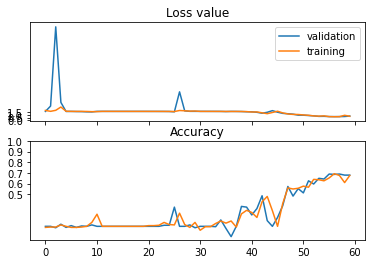

In [55]:
import pandas as pd

records     = pd.read_csv('testvalidation' +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_categorical_accuracy'],label="validation")
plt.plot(records['categorical_accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8,0.9,1.0])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()